# Intro
This notebook analyzes CNN verification model performance. Unlike OCSVM and Catboost models, 
it is run directly on image pairs. 
Requriements: test image data and metdata in numpy form, produced by cnn/train.py script.

In [13]:
import sys
sys.path.insert(0, '../../')
import os
import pandas as pd
import cv2
from sklearn.metrics import classification_report
import numpy as np
import glob
import random
from sklearn.metrics.pairwise import cosine_similarity
from machine_learning.cnn import create_model, create_feature_extractor
from tensorflow.python.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt
import matplotlib
%matplotlib notebook
matplotlib.style.use('default')
matplotlib.rcParams['figure.figsize']=[10,6]
pd.options.display.width = 0
pd.set_option('display.max_columns', None)

In [2]:
# load data
x_test = np.load('../../../data/x.npz.test.npz')
x_test = x_test.get(list(x_test.keys())[0])
y_test = np.load('../../../data/y.npz.test.npz')
y_test = y_test.get(list(y_test.keys())[0])
meta = pd.read_csv('../../../data/cnn_meta.csv')

In [3]:
# add fields
meta['filename'] = meta.master.str.extract('^.+/(.+)$')
meta['rend_type'] = meta.filename.str.extract('__[0-9]+__[0-9]+p_(.+)__[0-9]+\.?[0-9]+__[0-9]+')
meta['rend_res'] = meta.filename.str.extract('__[0-9]+__([0-9]+p)')
meta['tamper'] = y_test[..., 1]
meta['tamper_lab'] = meta.tamper > 0.5

In [4]:
feature_extractor = create_feature_extractor()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [5]:
features_a = feature_extractor.predict(x_test[...,0])
features_b = feature_extractor.predict(x_test[...,1])

In [14]:
sim = cosine_similarity(features_a, features_b)

In [40]:
sim_pred = 1 - np.diag(sim)
sim_pred_lab = sim_pred > 0.05
meta['sim_tamper_lab'] = sim_pred_lab

In [41]:
print(classification_report(meta['tamper_lab'], sim_pred_lab))

              precision    recall  f1-score   support

       False       0.88      0.49      0.63      1641
        True       0.75      0.96      0.84      2594

    accuracy                           0.78      4235
   macro avg       0.81      0.73      0.74      4235
weighted avg       0.80      0.78      0.76      4235



In [4]:
meta.groupby('rend_type').rend_type.count().sort_values()

rend_type
30-24fps                          2
black_and_white_25-60fps          3
24-60fps_gpu                      4
25-30fps                          4
25-60fps_gpu                      4
rotate_90_clockwise_24-30fps      4
watermark_25-24fps                5
rotate_90_clockwise_25-24fps      5
watermark-856x856_24-60fps        6
vignette_24-60fps_gpu             6
24-30fps                          7
30-60fps_gpu                      7
watermark_24-60fps_gpu            8
30-24fps_gpu                      9
rotate_90_counterclockwise       10
25-60fps                         11
25-24fps_gpu                     18
flip_vertical                    30
rotate_90_clockwise             266
vignette                        286
watermark                       309
flip_horizontal                 326
watermark-345x114               344
watermark-856x856               363
black_and_white                 363
Name: rend_type, dtype: int64

In [5]:
# load model
model = create_model()
model.load_weights('../output/verifier_cnn.hdf5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [6]:
# predict on test
y_pred = model.predict([x_test[..., 0], x_test[..., 1]])
y_pred_lab = y_pred[..., 1]>0.5

In [7]:
print(classification_report(meta['tamper_lab'], y_pred_lab))

              precision    recall  f1-score   support

       False       0.63      0.79      0.70      1709
        True       0.82      0.66      0.73      2334

    accuracy                           0.72      4043
   macro avg       0.72      0.73      0.72      4043
weighted avg       0.74      0.72      0.72      4043



In [8]:
print('Hardest renditions by type')
hard_rend = meta[y_pred_lab!=meta.tamper_lab].groupby('rend_type').rend_type.count().sort_values().tail(15)
print(hard_rend)

Hardest renditions by type
rend_type
24-30fps                        2
25-60fps                        3
watermark-856x856_24-60fps      3
30-24fps_gpu                    4
25-60fps_gpu                    4
rotate_90_counterclockwise      8
watermark                      15
flip_vertical                  17
25-24fps_gpu                   18
watermark-345x114              52
watermark-856x856              63
rotate_90_clockwise            80
black_and_white                88
vignette                      162
flip_horizontal               295
Name: rend_type, dtype: int64


In [9]:
np.min(x_test)

-1.0

<IPython.core.display.Javascript object>


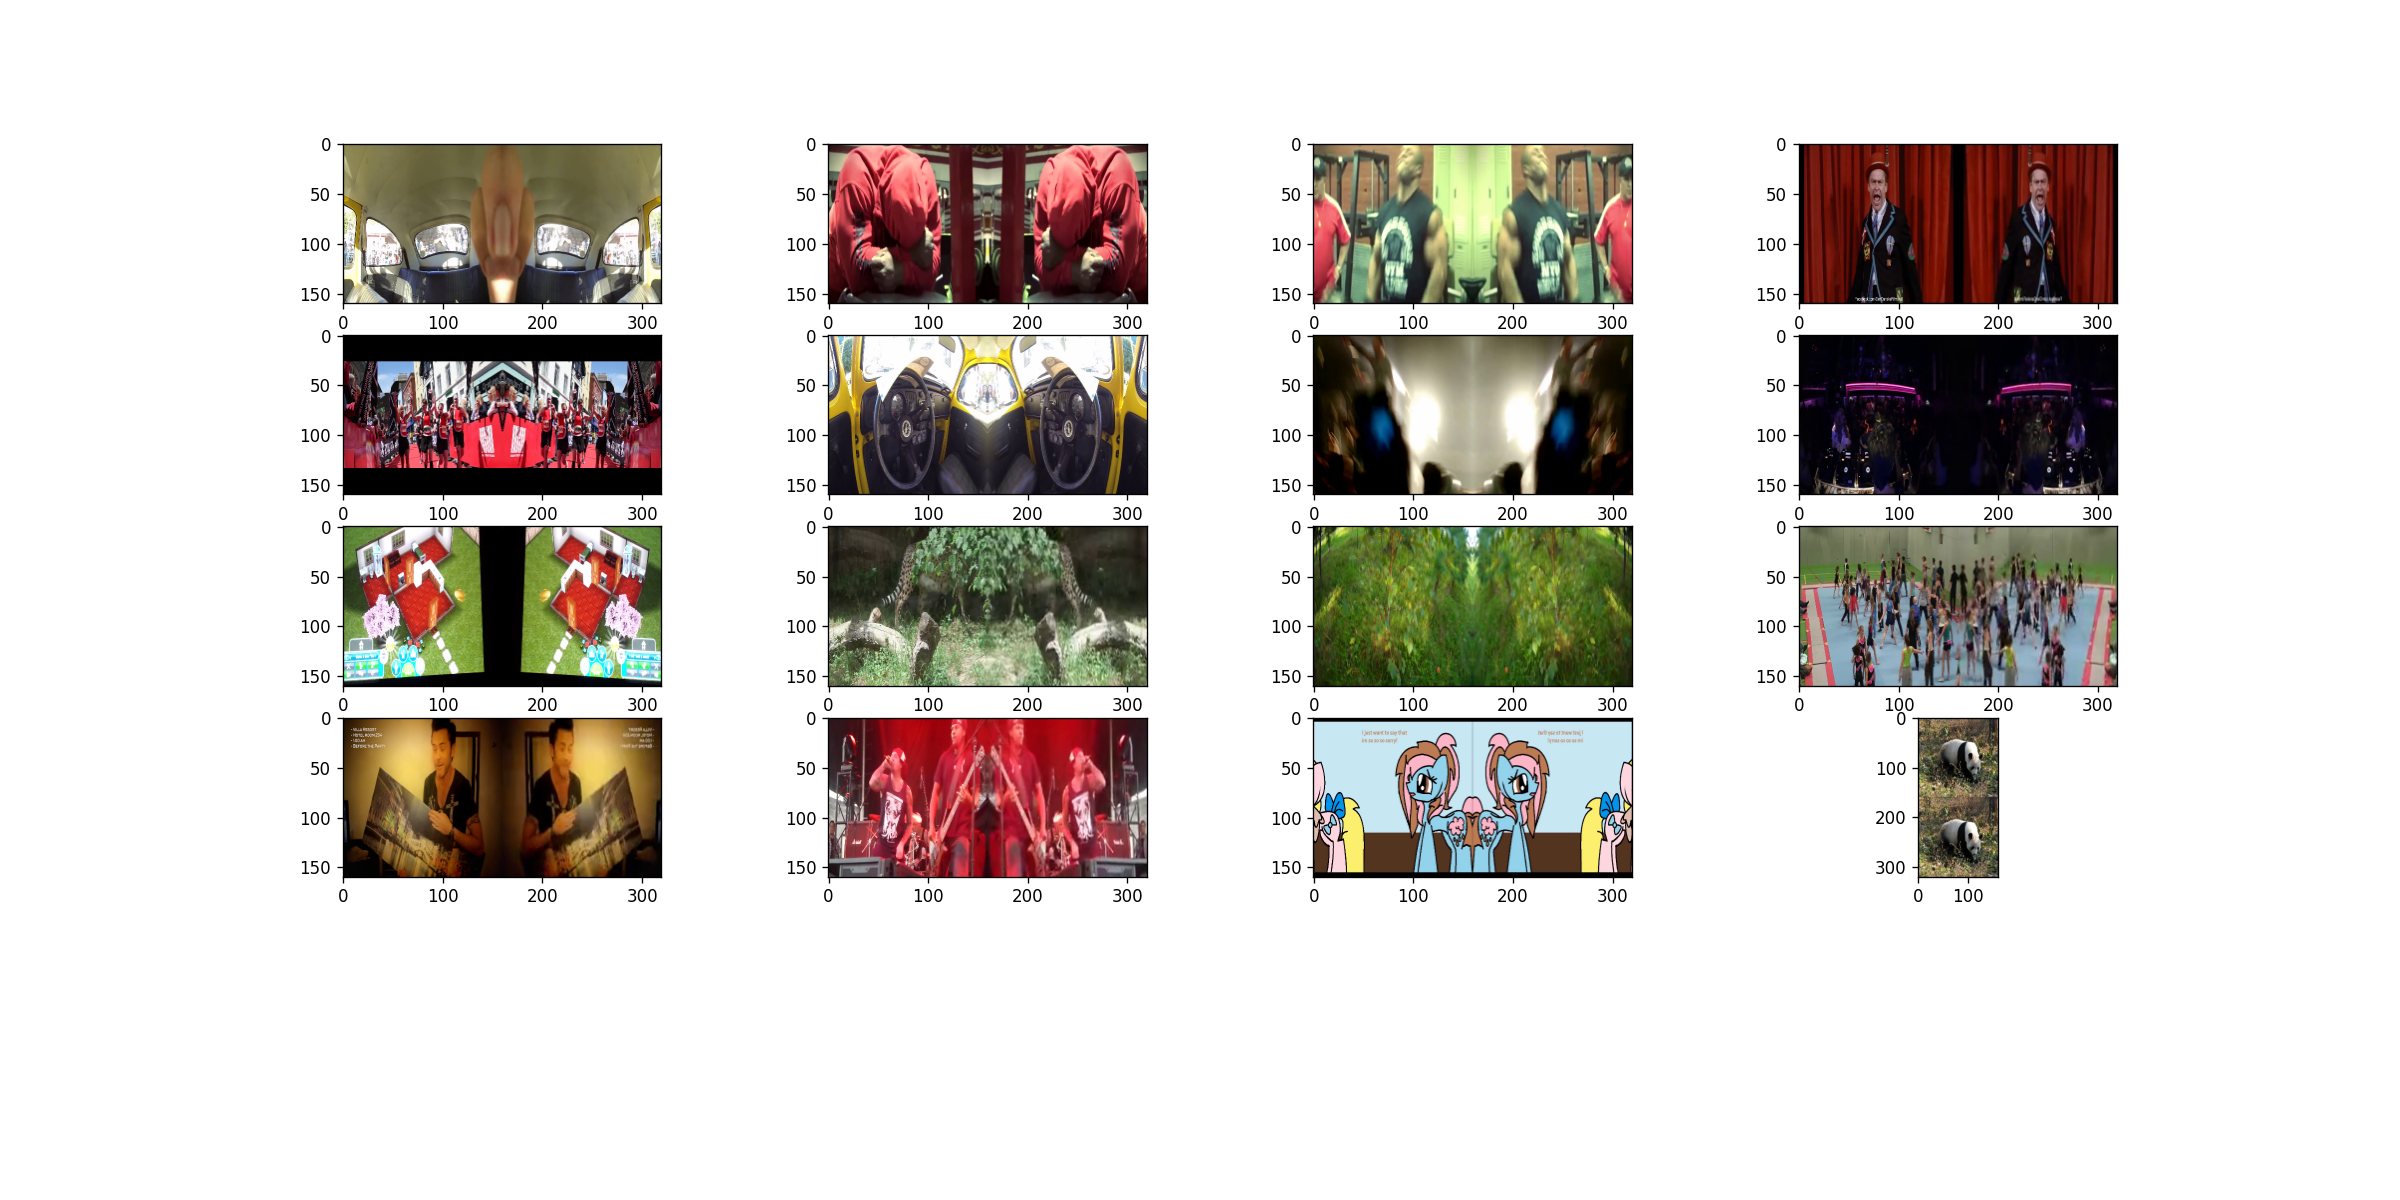

In [10]:
# show some of hardest type samples
hardest_type = hard_rend.index[-1]
hardest_idx = np.where(np.logical_and(y_pred_lab!=meta.tamper_lab, meta.rend_type==hardest_type, y_pred_lab==0))[0]
plt.figure(figsize=(20,10))
columns = 4
n_imgs = 16
hardest_idx = hardest_idx[:n_imgs]
plot_num = 0
for i in hardest_idx:
    image = np.concatenate([x_test[i][...,0], x_test[i][...,1]], axis=1)
    image = ((image+1)*127).astype(np.uint8)
    plt.subplot(n_imgs / columns + 1, columns, plot_num + 1)
    plt.imshow(image)
    plot_num+=1

In [11]:
meta.rend_type.unique()

array(['watermark-345x114', 'black_and_white', nan, 'flip_horizontal',
       'vignette', 'watermark-856x856', 'watermark', 'flip_vertical',
       'rotate_90_clockwise', 'watermark_25-24fps', '25-24fps_gpu',
       '30-24fps_gpu', '24-60fps_gpu', 'watermark_24-60fps_gpu',
       'rotate_90_clockwise_25-24fps', '25-60fps', '30-60fps_gpu',
       '24-30fps', '25-60fps_gpu', '25-30fps', 'vignette_24-60fps_gpu',
       'rotate_90_counterclockwise', 'watermark-856x856_24-60fps',
       '30-24fps', 'black_and_white_25-60fps',
       'rotate_90_clockwise_24-30fps'], dtype=object)

In [20]:
# check colorspace sample
#img1 = cv2.imread('../../testing/tests/data/fix_scene_move_1.png')[...,::-1]
#img2 = cv2.imread('../../testing/tests/data/fix_scene_move_2.png')[...,::-1]
img1 = cv2.imread('../../testing/tests/data/panda.jpg')[...,::-1]
img2 = cv2.imread('../../testing/tests/data/panda.jpg')[...,::-1]
#img1 = cv2.imread('../../testing/tests/data/codec_impl_color_diff_2.png')[...,::-1]
#img2 = cv2.imread('../../testing/tests/data/codec_impl_color_diff_1.png')[...,::-1]
img1 = preprocess_input(img1)
img2 = preprocess_input(img2)
img1 = cv2.resize(img1, (160, 160))
img2 = cv2.resize(img2, (160, 160))
plt.imshow(np.concatenate([((img1+1)*127).astype(np.uint8), ((img2+1)*127).astype(np.uint8)], axis=0))
model.predict([img1[None], img2[None]])[...,1]

array([0.8321371], dtype=float32)

(array([  45,  109,  122,  123,  192,  290,  516,  525,  566,  632,  634,
         696,  836,  856,  872,  880,  932,  936,  942,  978, 1001, 1060,
        1093, 1128, 1269, 1279, 1385, 1397, 1403, 1469, 1535, 1609, 1689,
        1822, 2005, 2146, 2323, 2346, 2383, 2387, 2391, 2398, 2442, 2603,
        2625, 2671, 2714, 2768, 2809, 2834, 2891, 2947, 2953, 3008, 3041,
        3215, 3435, 3529, 3568, 3630, 3672, 3691, 3859, 3886, 3901, 3926,
        3947, 3959]),)